In [178]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [157]:
sents_join = ["I feel hungry", "tensorflow is very difficult", "tensorflow is a framework for deep learning", "tensorflow is very fast changing"]
sents = [sent.split(" ") for sent in sents_join]

sents_pos = [["pronoun", "verb", "adjective"], ["noun", "verb", "adverb", "adjective"], ["noun", "verb", "determiner", "noun", "preposition", "adjective", "noun"], ["noun", "verb", "adverb", "adjective", "verb"]]

In [158]:
sents

[['I', 'feel', 'hungry'],
 ['tensorflow', 'is', 'very', 'difficult'],
 ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
 ['tensorflow', 'is', 'very', 'fast', 'changing']]

In [159]:
word_list = sum(sents, [])
word_list = ["<pad>"] + list(set(word_list))

idx2word = {idx:word for idx, word in enumerate(word_list)}
word2idx = {word:idx for idx, word in enumerate(word_list)}

pos_list = sum(sents_pos, [])
pos_list = ["<pad>"] + list(set(pos_list))

idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}

In [160]:
sents_idx = [[word2idx[word] for word in sent] for sent in sents]
sents_pos_idx = [[pos2idx[pos] for pos in sent_pos] for sent_pos in sents_pos]

max_seq = 10

sents_pad = tf.keras.preprocessing.sequence.pad_sequences(sents_idx, max_seq, padding="post", truncating="post", value=0)
sents_pos_pad = tf.keras.preprocessing.sequence.pad_sequences(sents_pos_idx, max_seq, padding="post", truncating="post", value=0)

sents_mask = np.array(sents_pad!=0, dtype=np.int32)
sents_len = [len(sent) for sent in sents]

In [197]:
n_cls = len(pos2idx)
hid_dim = 10

in_dim = len(word2idx)
out_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(in_dim, out_dim, trainable=False, mask_zero=True, input_length=max_seq, embeddings_initializer=tf.keras.initializers.Constant(one_hot)))
model.add(tf.keras.layers.SimpleRNN(units=hid_dim, return_sequences=True, return_state=False))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_cls)))

In [198]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 15)            225       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10, 10)            260       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 8)             88        
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


In [199]:
def loss_fn(model, sent, sent_pos, sent_len, max_seq):
    masking = tf.sequence_mask(sent_len, maxlen=max_seq, dtype=tf.float32)
    valid_timestep = tf.cast(sent_len, dtype=tf.float32)
    
    loss_word = tf.keras.losses.sparse_categorical_crossentropy(y_true=sent_pos, y_pred=model(sent), from_logits=True) * masking
    loss_sent = tf.reduce_sum(loss_word, axis=-1) / valid_timestep
    loss_tot = tf.reduce_mean(loss_sent, axis=-1)
    return loss_tot

lr = 0.1
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(lr)

train = tf.data.Dataset.from_tensor_slices((sents_pad, sents_pos_pad, sents_len)).shuffle(len(sents_pad)).batch(batch_size)

In [200]:
loss_hist = []
for epoch in range(epochs):
    loss_sum = 0
    step = 0
    for x_mb, y_mb, x_mb_len in train:
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x_mb, y_mb, x_mb_len, max_seq)
        grads = tape.gradient(loss, model.variables)
        opt.apply_gradients(zip(grads, model.variables))
        
        loss_sum += loss
        step += 1
    avg_loss = loss_sum / step
    loss_hist.append(avg_loss)
    
    print(f"epoch : {epoch+1:>3d} | loss : {avg_loss:>5.3f}")

epoch :   1 | loss : 2.243
epoch :   2 | loss : 1.235
epoch :   3 | loss : 0.611
epoch :   4 | loss : 0.269
epoch :   5 | loss : 0.096
epoch :   6 | loss : 0.044
epoch :   7 | loss : 0.020
epoch :   8 | loss : 0.010
epoch :   9 | loss : 0.006
epoch :  10 | loss : 0.004
epoch :  11 | loss : 0.003
epoch :  12 | loss : 0.002
epoch :  13 | loss : 0.002
epoch :  14 | loss : 0.001
epoch :  15 | loss : 0.001
epoch :  16 | loss : 0.001
epoch :  17 | loss : 0.001
epoch :  18 | loss : 0.001
epoch :  19 | loss : 0.001
epoch :  20 | loss : 0.001
epoch :  21 | loss : 0.001
epoch :  22 | loss : 0.001
epoch :  23 | loss : 0.000
epoch :  24 | loss : 0.000
epoch :  25 | loss : 0.000
epoch :  26 | loss : 0.000
epoch :  27 | loss : 0.000
epoch :  28 | loss : 0.000
epoch :  29 | loss : 0.000
epoch :  30 | loss : 0.000


In [201]:
pred = model.predict(sents_pad)
pred = tf.argmax(pred, axis=-1)

pred_pos = [[idx2pos[idx] for idx in sent_pos] for sent_pos in pred.numpy()]

acc = tf.reduce_mean(tf.cast(pred==sents_pos_pad, dtype=tf.float32)).numpy()

In [206]:
model.predict(sents_pad)

array([[[-9.18561161e-01, -4.97439718e+00,  1.71691346e+00,
         -1.46633434e+00, -5.89889288e-03, -4.06633949e+00,
          2.07200933e+00,  1.00619383e+01],
        [-9.73298967e-01, -1.99145222e+00, -2.23064995e+00,
         -4.09522629e+00,  1.16070776e+01, -2.50251961e+00,
         -1.55105090e+00, -7.00548291e-01],
        [-2.54715681e+00, -1.55980575e+00,  6.39635980e-01,
          9.57277107e+00, -1.91104865e+00, -6.10606670e-02,
         -4.11874866e+00, -7.77354717e-01],
        [-2.54715681e+00, -1.55980575e+00,  6.39635980e-01,
          9.57277107e+00, -1.91104865e+00, -6.10606670e-02,
         -4.11874866e+00, -7.77354717e-01],
        [-2.54715681e+00, -1.55980575e+00,  6.39635980e-01,
          9.57277107e+00, -1.91104865e+00, -6.10606670e-02,
         -4.11874866e+00, -7.77354717e-01],
        [-2.54715681e+00, -1.55980575e+00,  6.39635980e-01,
          9.57277107e+00, -1.91104865e+00, -6.10606670e-02,
         -4.11874866e+00, -7.77354717e-01],
        [-2.5471

In [202]:
acc

0.475

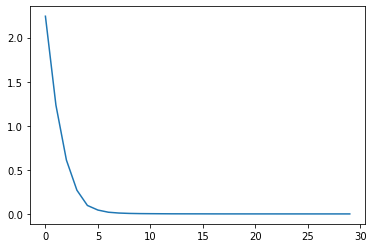

In [203]:
plt.plot(loss_hist)